#### Combating Employee Attrition in IT Industry                                                                                     
- Applied data visualization techniques to explore distribution and correlation of employee demographics and churn rate. 
- Built random forest model and elastic net regression model to predict employee churn rate with 86% accuracy in R.  
- Data source: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [2]:
library(dplyr)
library(Amelia)
library(tidyverse)
library(ggplot2)
library(Hmisc)
library(corrplot)
library(psych)
library(caret)
library(plyr)
library(repr)
library(randomForest)
require(caTools)
library(splitstackshape)
library(rsample)              #for stratify sampling
library(class)                #for classification
library(ggpubr)

In [3]:
attrition = read.csv("WA_Fn-UseC_-HR-Employee-Attrition.csv" , na.strings = c(""))

#### Data Pre-processing

In [4]:
#checking for NA values 
str(attrition)

'data.frame':	1470 obs. of  35 variables:
 $ ï..Age                  : int  41 49 37 33 27 32 59 30 38 36 ...
 $ Attrition               : Factor w/ 2 levels "No","Yes": 2 1 2 1 1 1 1 1 1 1 ...
 $ BusinessTravel          : Factor w/ 3 levels "Non-Travel","Travel_Frequently",..: 3 2 3 2 3 2 3 3 2 3 ...
 $ DailyRate               : int  1102 279 1373 1392 591 1005 1324 1358 216 1299 ...
 $ Department              : Factor w/ 3 levels "Human Resources",..: 3 2 2 2 2 2 2 2 2 2 ...
 $ DistanceFromHome        : int  1 8 2 3 2 2 3 24 23 27 ...
 $ Education               : int  2 1 2 4 1 2 3 1 3 3 ...
 $ EducationField          : Factor w/ 6 levels "Human Resources",..: 2 2 5 2 4 2 4 2 2 4 ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 7 8 10 11 12 13 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 1 4 3 4 4 3 ...
 $ Gender                  : Factor w/ 2 levels "Female","Male": 1 2 2 1 2 2 1 2 2 2 ...
 $ HourlyRate              : int  94 6

In [5]:
#checking for missing values
# missmap(attrition, main = "Missing values vs observed")

In [6]:
#converting numeric categorical variables to factors
attrition$Education <-   as.factor(attrition$Education)
attrition$EnvironmentSatisfaction <-   as.factor(attrition$EnvironmentSatisfaction)
attrition$JobLevel <-   as.factor(attrition$JobLevel)
attrition$JobInvolvement <-   as.factor(attrition$JobInvolvement)
attrition$JobSatisfaction <-   as.factor(attrition$JobSatisfaction)
attrition$PerformanceRating <-   as.factor(attrition$PerformanceRating)
attrition$RelationshipSatisfaction <-   as.factor(attrition$RelationshipSatisfaction)
attrition$StockOptionLevel <-   as.factor(attrition$StockOptionLevel)
attrition$WorkLifeBalance <-   as.factor(attrition$WorkLifeBalance)

In [7]:
# dropping irrelavant columns- over18, EmployeeCount, EmployeeNumber
data <- subset(attrition,select=c(1:8,11:26,28:35))

#### Exploring relationships within data

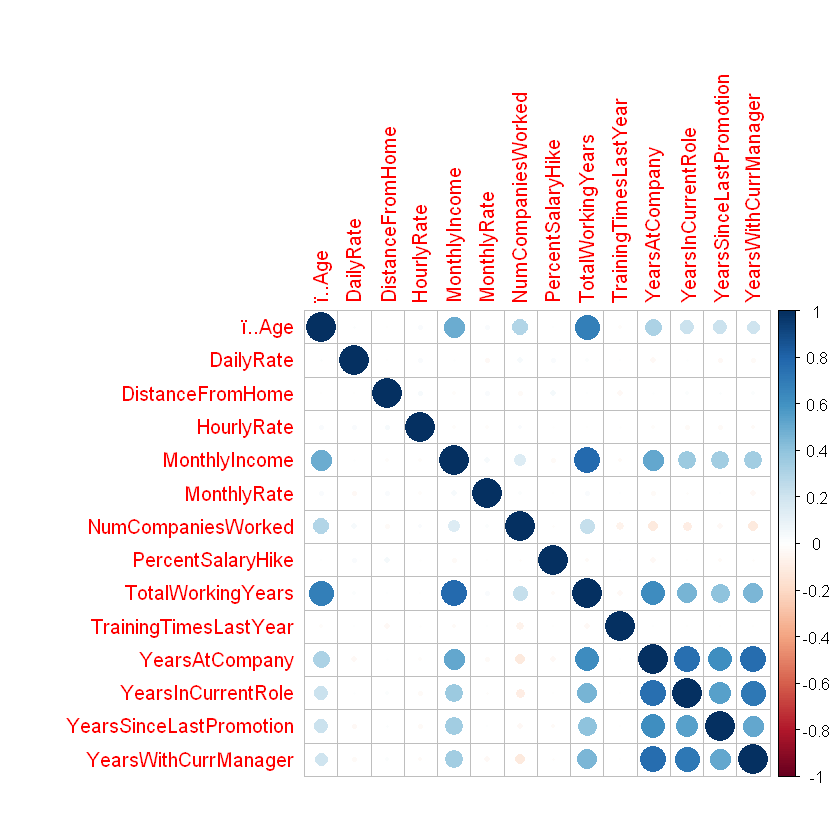

In [8]:
#correlation
data_numeric <- select_if(data, is.numeric)
cordata <- cor(data_numeric)
corrplot(cordata)

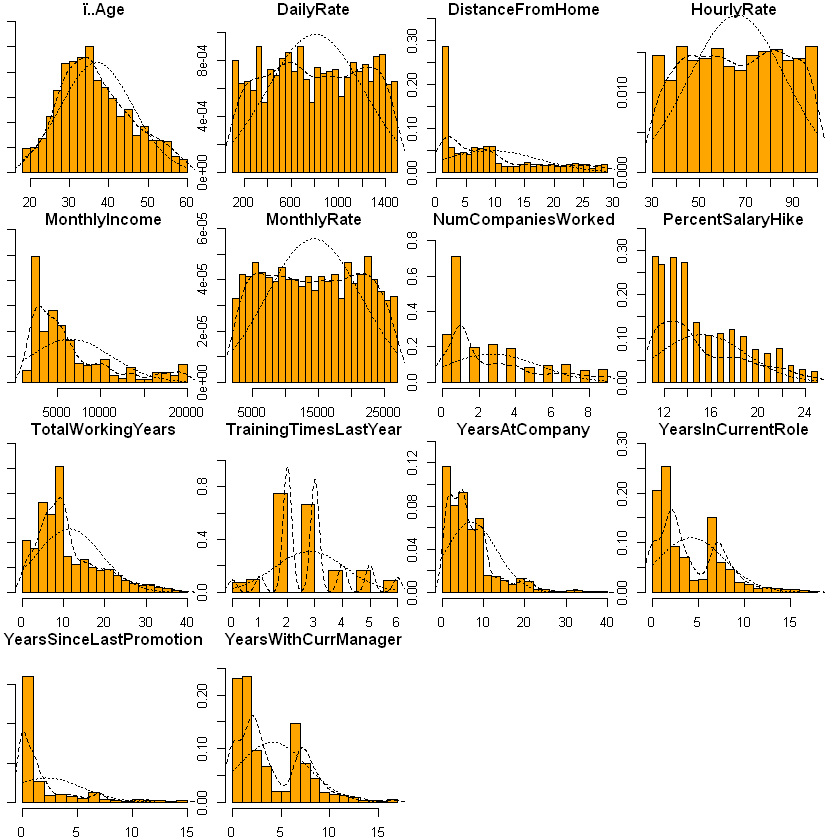

In [9]:
#distribution
multi.hist(data_numeric, bcol="orange",dcol = "black")

In [10]:
# distribution of attribution rate across different factors
distri.1<-ggplot(data = data,aes(fill = Attrition, x = JobSatisfaction )) + geom_bar(position = "fill")
distri.2<-ggplot(data = data,aes(fill = Attrition, x = Gender )) + geom_bar(position = "fill")
distri.3<-ggplot(data = data,aes(fill = Attrition, x = MaritalStatus )) + geom_bar(position = "fill")

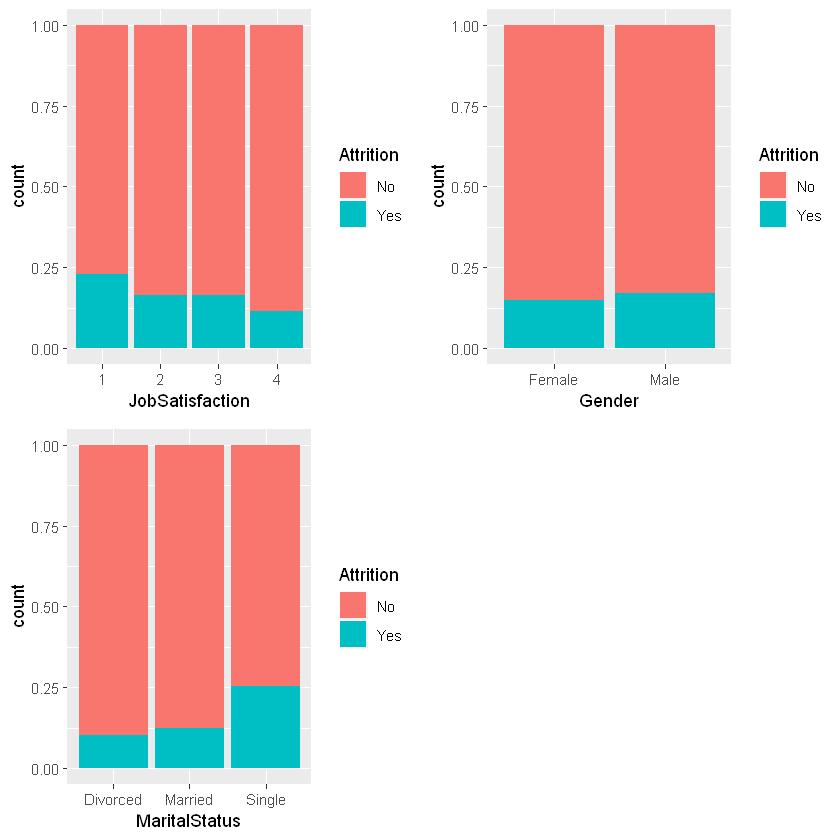

In [11]:
ggarrange(distri.1, distri.2, distri.3)

Warning message in as_grob.default(plot):
"Cannot convert object of class numeric into a grob."

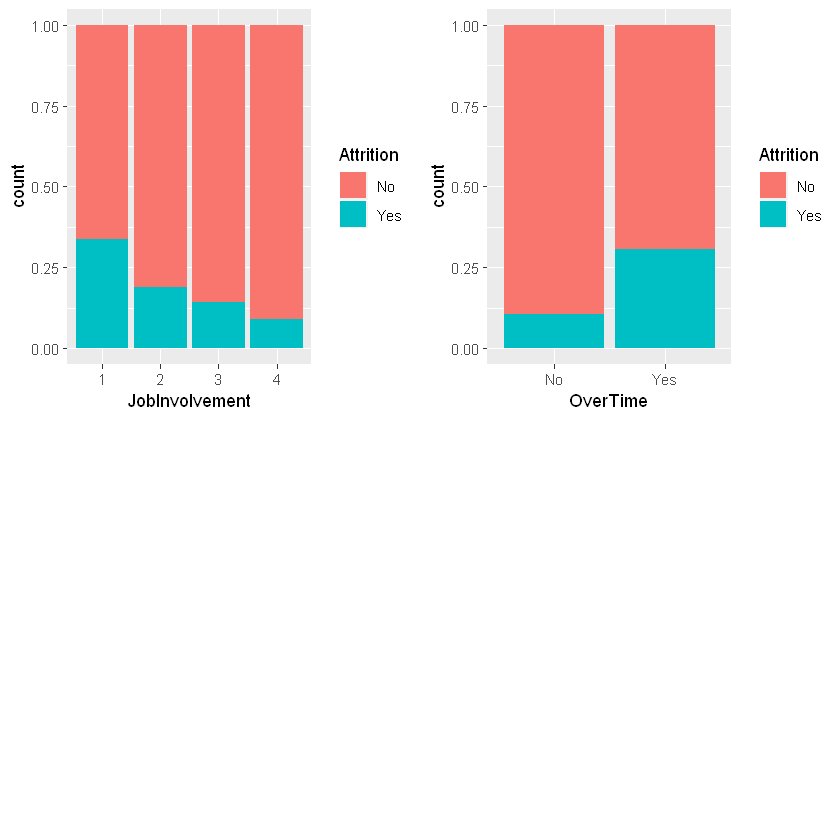

In [12]:
#attrtionrate doubles if they are single
distri.4<-ggplot(data = data,aes(fill = Attrition, x = JobInvolvement )) + geom_bar(position = "fill")
#clear correlation
distri.5<-ggplot(data = data,aes(fill = Attrition, x = OverTime )) + geom_bar(position = "fill")
ggarrange(distri.4, distri.5,col=2)

#### Model Development

In [14]:
set.seed(100)
data1 = subset(data,select = c(1:3,5:19,21:32))
data1$Attrition <- ifelse(data1$Attrition == "Yes", 1, 0)

In [15]:
#sample data creation
sample_index <- initial_split(data1,prop = 3/4,strata = Attrition)
train <- training(sample_index)
test <- testing(sample_index)

In [16]:
#function to calculate R2
# Compute R^2 from true and predicted values
eval_results <- function(true, predicted, df) {
  SSE <- sum((predicted - true)^2)
  SST <- sum((true - mean(true))^2)
  R_square <- 1 - SSE / SST
  RMSE = sqrt(SSE/nrow(df))
  
  # Model performance metrics
  data.frame(
    RMSE = RMSE,
    Rsquare = R_square
  )
  
}

In [17]:
# Elastic net regularization
train_cont <- trainControl(method = "repeatedcv",
                           number = 10,
                           repeats = 5,
                           search = "random",
                           verboseIter = TRUE)

In [18]:
# Train the model
elastic_reg <- train(Attrition ~ .,
                     data = data1,
                     method = "glmnet",
                     preProcess = c("center", "scale"),
                     tuneLength = 10,
                     trControl = train_cont)

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

+ Fold01.Rep1: alpha=0.8796, lambda=0.056569 
- Fold01.Rep1: alpha=0.8796, lambda=0.056569 
+ Fold01.Rep1: alpha=0.9115, lambda=0.069859 
- Fold01.Rep1: alpha=0.9115, lambda=0.069859 
+ Fold01.Rep1: alpha=0.3903, lambda=0.070190 
- Fold01.Rep1: alpha=0.3903, lambda=0.070190 
+ Fold01.Rep1: alpha=0.8652, lambda=0.773339 
- Fold01.Rep1: alpha=0.8652, lambda=0.773339 
+ Fold01.Rep1: alpha=0.5146, lambda=0.002566 
- Fold01.Rep1: alpha=0.5146, lambda=0.002566 
+ Fold01.Rep1: alpha=0.7412, lambda=0.318276 
- Fold01.Rep1: alpha=0.7412, lambda=0.318276 
+ Fold01.Rep1: alpha=0.9602, lambda=0.043840 
- Fold01.Rep1: alpha=0.9602, lambda=0.043840 
+ Fold01.Rep1: alpha=0.5697, lambda=1.325577 
- Fold01.Rep1: alpha=0.5697, lambda=1.325577 
+ Fold01.Rep1: alpha=0.3111, lambda=0.253182 
- Fold01.Rep1: alpha=0.3111, lambda=0.253182 
+ Fold01.Rep1: alpha=0.7433, lambda=0.009238 
- Fold01.Rep1: alpha=0.7433, lambda=0.009238 
+ Fold02.Rep1: alpha=0.8796, lambda=0.056569 
- Fold02.Rep1: alpha=0.8796, lambd

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

Aggregating results
Selecting tuning parameters
Fitting alpha = 0.515, lambda = 0.00257 on full training set


In [19]:
elastic_reg$coefnames

[1] "ï..Age"                           "BusinessTravelTravel_Frequently" 
 [3] "BusinessTravelTravel_Rarely"      "DepartmentResearch & Development"
 [5] "DepartmentSales"                  "DistanceFromHome"                
 [7] "Education2"                       "Education3"                      
 [9] "Education4"                       "Education5"                      
[11] "EducationFieldLife Sciences"      "EducationFieldMarketing"         
[13] "EducationFieldMedical"            "EducationFieldOther"             
[15] "EducationFieldTechnical Degree"   "EnvironmentSatisfaction2"        
[17] "EnvironmentSatisfaction3"         "EnvironmentSatisfaction4"        
[19] "GenderMale"                       "HourlyRate"                      
[21] "JobInvolvement2"                  "JobInvolvement3"                 
[23] "JobInvolvement4"                  "JobLevel2"                       
[25] "JobLevel3"                        "JobLevel4"                       
[27] "JobLevel5"                        "JobRoleHuman Resources"          
[29] "JobRoleLaboratory Technician"     "JobRoleManager"                  
[31] "JobRoleManufacturing Director"    "JobRoleResearch Director"        
[33] "JobRoleResearch Scientist"        "JobRoleSales Executive"          
[35] "JobRoleSales Representative"      "JobSatisfaction2"                
[37] "JobSatisfaction3"                 "JobSatisfaction4"                
[39] "MaritalStatusMarried"             "MaritalStatusSingle"             
[41] "MonthlyIncome"                    "MonthlyRate"                     
[43] "NumCompaniesWorked"               "OverTimeYes"                     
[45] "PercentSalaryHike"                "PerformanceRating4"              
[47] "RelationshipSatisfaction2"        "RelationshipSatisfaction3"       
[49] "RelationshipSatisfaction4"        "StockOptionLevel1"               
[51] "StockOptionLevel2"                "StockOptionLevel3"               
[53] "TotalWorkingYears"                "TrainingTimesLastYear"           
[55] "WorkLifeBalance2"                 "WorkLifeBalance3"                
[57] "WorkLifeBalance4"                 "YearsAtCompany"                  
[59] "YearsInCurrentRole"               "YearsSinceLastPromotion"         
[61] "YearsWithCurrManager"

In [20]:
colnames(test)

[1] "ï..Age"                   "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EnvironmentSatisfaction" 
 [9] "Gender"                   "HourlyRate"              
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "MonthlyRate"              "NumCompaniesWorked"      
[19] "OverTime"                 "PercentSalaryHike"       
[21] "PerformanceRating"        "RelationshipSatisfaction"
[23] "StockOptionLevel"         "TotalWorkingYears"       
[25] "TrainingTimesLastYear"    "WorkLifeBalance"         
[27] "YearsAtCompany"           "YearsInCurrentRole"      
[29] "YearsSinceLastPromotion"  "YearsWithCurrManager"

In [21]:
y_test = test$Attrition
x_test = test[,-2]

In [22]:
# Make predictions on training set
predictions_train <- predict(elastic_reg, x_test)
eval_results(y_test, predictions_train, test) 

RMSE,Rsquare
0.31979,0.2420176


In [23]:
# Make predictions on test set
predictions_test <- predict(elastic_reg, x_test)
eval_results(y_test, predictions_test, test)


RMSE,Rsquare
0.31979,0.2420176


In [ ]:
#Random Forest 
sample = sample.split(data1$num, SplitRatio = .75)
train = subset(data1, sample == TRUE)
test  = subset(data1, sample == FALSE)
rf <- randomForest(
  Attrition ~ .,
  data= train,ntree = 500,mtry = 4)

In [31]:
importance(rf)

,MeanDecreaseGini
ï..Age,23.129933
DistanceFromHome,18.463081
MonthlyIncome,26.668084
NumCompaniesWorked,12.221943
PercentSalaryHike,12.849975
TotalWorkingYears,19.449978
TrainingTimesLastYear,9.645079
YearsAtCompany,19.084931
BusinessTravel,6.483007
Department,3.518031


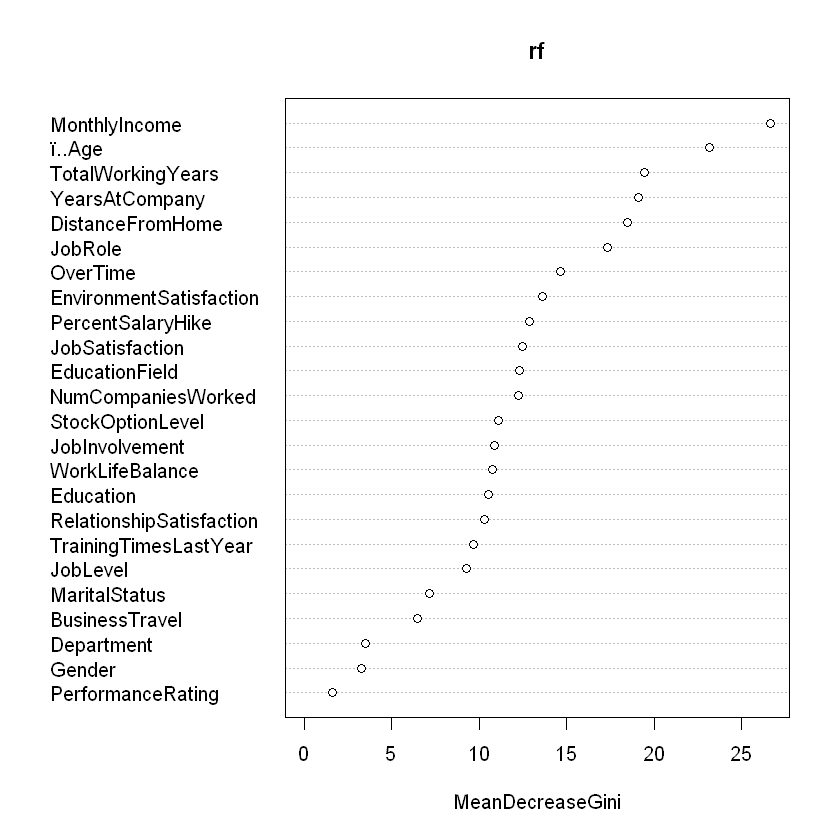

In [32]:
varImpPlot(rf)

In [33]:
rf


Call:
 randomForest(formula = Attrition ~ ., data = train, ntree = 500,      mtry = 4) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 13.51%
Confusion matrix:
     No Yes class.error
No  916   9  0.00972973
Yes 140  38  0.78651685

In [34]:
pred = predict(rf, newdata=test[-9])
cm = table(test[,9], pred)
cm

     pred
       No Yes
  No  305   3
  Yes  52   7

#### Conclusion
- OOS accuracy is 85 %i.e. model correctly identifying whether 86 percent people will churn or not.
- Precision = 70%. Out of total employees flagged by model as likely to churn, 70% do. 
- Recall = 12%. Out of all employees likely to churn, Model can identify 12% of those. 
- Monthly Income and age are the most important variables to split the tree. 
- With high Accuracy and precision numbers but low recall number, our model can accurately save the company from incurring employee replacement costs. All those employees who are least likely to churn can be accurately identified and hence left out of targeting strategies.

#### Limitations
- Sample data is disproportionate in terms of attrition distribution, only 16% of the employees have churned in the current dataset. This might lead to a biased model.  
- We are training only 1000 data points who are majorly based out of IT firms, this might create potential bias when extending this product to other firms. 
- Survey response has been used as an input to the model, which might result in selection bias.  